# Аналитика 

 В нашем распоряжении есть данные с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

Необходимо изучить:
- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

###  Открытие файла с данными

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')

orders = pd.read_csv('/datasets/orders_log.csv')

costs = pd.read_csv('/datasets/costs.csv')

In [3]:
visits.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Таблица visits (лог сервера с информацией о посещениях сайта):
- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь

Изучая таблицу можно отметить что пропуски отсутствуют, необходимо привести даты к нужному типу.

In [4]:
#Приведем к нижнему регистру названия столбцов
visits.columns = visits.columns.str.lower()

In [5]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts','uid']

In [6]:
#приводим даты к нужному типу.
visits['end_ts'] =pd.to_datetime( visits['end_ts'])

visits['start_ts'] =pd.to_datetime( visits['start_ts'])

In [7]:
orders.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Таблица orders (информация о заказах):
- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа

В таблице заказов 3 столбца, данные полные, заменим тип данных даты заказа

In [8]:
orders.columns = orders.columns.str.lower()

In [9]:
orders.columns = ['buy_ts', 'revenue', 'uid']

In [10]:
orders['buy_ts'] = pd.to_datetime( orders['buy_ts'])

In [11]:
costs.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Таблица costs (информация о затратах на маркетинг):
- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

В таблице маркетинга также полные данные, заменим тип даты

In [12]:
costs['dt'] = pd.to_datetime( costs['dt'])

###  Построим отчёты и посчитаем метрики

### Продукт
- Сколько людей пользуются в день, неделю, месяц?
- Сколько сессий в день?
- Сколько длится одна сессия?
- Как часто люди возвращаются?

#### проверим сколько людей пользуются продуктом в день, неделю, месяц?

In [13]:
#Чтобы посчитать недельное и месячное использование, выделим в отдельные столбцы год, месяц и неделю, а также полную дату.
visits['session_date'] = visits['start_ts'].dt.date

visits['session_week'] = visits['start_ts'].dt.week

visits['session_month'] = visits['start_ts'].dt.month

visits['first_of_month'] = visits['start_ts'].astype('datetime64[M]')

visits['session_year'] = visits['start_ts'].dt.year


Посчитаем метрики. Сгруппируем данные по уникальным пользователям и найдём среднее

In [14]:
date_dau=visits.groupby(['session_year','session_date']).agg({'uid': 'nunique'})


In [15]:
date_dau_2017=date_dau.query('session_year == 2017')
date_dau_2017['uid'].mean()

845.2803738317757

In [16]:
date_dau_2018=date_dau.query('session_year == 2018')
date_dau_2018['uid'].mean()

997.46

In [17]:
DAU = visits.groupby('session_date').agg({'uid': 'nunique'}).mean()
DAU

uid    907.991758
dtype: float64

DAU — количество уникальных пользователей в день в среднем составляет 908 человек

In [18]:
date_wau=visits.groupby(['session_year','session_week']).agg({'uid': 'nunique'})


In [19]:
date_wau_2017=date_wau.query('session_year == 2017')
date_wau_2017['uid'].mean()

5341.580645161291

In [20]:
date_wau_2018=date_wau.query('session_year == 2018')
date_wau_2018['uid'].mean()

6244.181818181818

In [21]:
WAU = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean()
WAU

uid    5716.245283
dtype: float64

WAU — количество уникальных пользователей в неделю в среднем составляет  5716 человек

In [22]:
date_mau=visits.groupby(['session_year', 'first_of_month']).agg({'uid': 'nunique'}).reset_index()


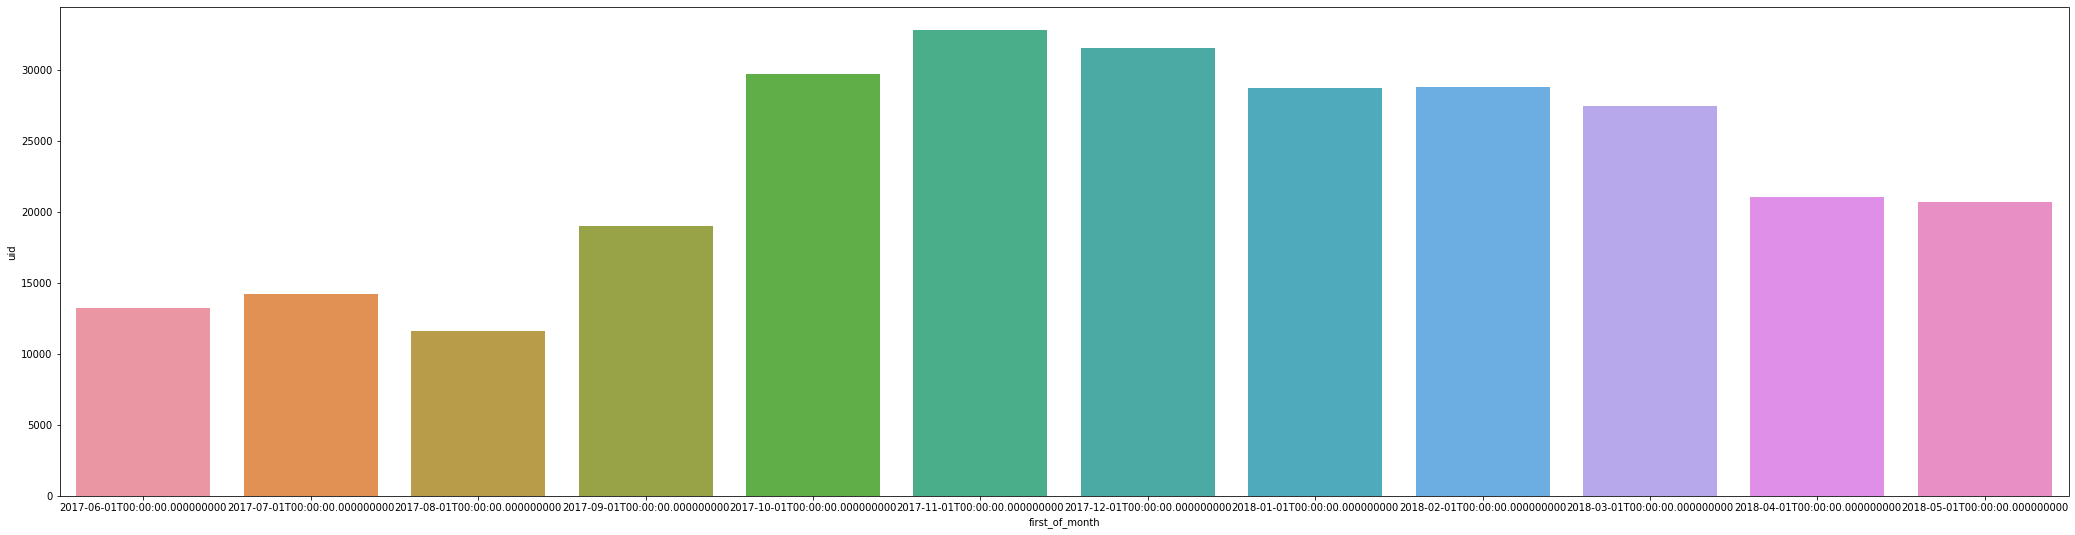

In [23]:
plt.figure(figsize=(36, 9))
ax = sns.barplot(x = "first_of_month", y="uid", data=date_mau)
plt.title='MAU'
ax.set_xlabel='month'
ax.set_ylabel='uid'
plt.show()

## <span style="color:red">ДОПОЛНЕНИЕ</span>
Исходя из месячной статистики можно увидеть рост колличества новых пользователей в течении 2018 года

In [24]:
MAU = visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean()
MAU

uid    23228.416667
dtype: float64

MAU — количество уникальных пользователей в месяц в среднем составляет 23228 человек

недельный Sticky Factor - Степень вовлечения

In [25]:
sticky_factor_week = DAU/WAU*100
sticky_factor_week

uid    15.884409
dtype: float64

Sticky Factor (месячный)

In [26]:
sticky_factor_month = DAU/MAU*100
sticky_factor_month

uid    3.90897
dtype: float64

Чем выше этот показатель, тем регулярнее пользователи заходят в приложение.

Рассмотрим активных пользователей в трёх измерениях:
- количество уникальных пользователей в день в среднем составляет 908 человек
- количество уникальных пользователей в неделю в среднем составляет 5716 человек
- количество уникальных пользователей в месяц в среднем составляет 23228 человек
Не смотря на то что изначально часть аудитории имеет интерес к возврату на данный ресурс по итогам месяца можно сказать что возврат пользователей близок к 0

#### Посчитаем сколько сессий в день?

In [27]:
#Из таблицы визитов сгруппируем новую таблицу с количеством сессий по каждому месяцу
session_per_day = visits.groupby(['session_year','session_month']).agg({'session_date':['count','nunique']})
session_per_day.columns = ['session_count','days']
session_per_day['session_per_days']=session_per_day['session_count']/session_per_day['days']


In [28]:
session_count_mean = visits.groupby('session_date').agg({'uid':'count'}).mean()
session_count_mean

uid    987.362637
dtype: float64

В среднем 987 сессий в день, максимальное колличество сессий приходится на ноябрь

#### Рассмотрим сколько длится одна сессия?

In [29]:
#добавим столбец с продолжительностью сессии
visits['session_duration'] = (visits['end_ts'] - visits['start_ts']).dt.total_seconds()/60
visits['session_duration'].describe()

count    359400.000000
mean         10.717095
std          16.618796
min         -46.000000
25%           2.000000
50%           5.000000
75%          14.000000
max         711.000000
Name: session_duration, dtype: float64

In [30]:
#Продолжительность сессии не может быть отрицательным числом, поэтому сделаем срез оставив лишь положительные значения
visits = visits.query('session_duration >= 0')
visits['session_duration'].describe()

count    359398.000000
mean         10.717371
std          16.618420
min           0.000000
25%           2.000000
50%           5.000000
75%          14.000000
max         711.000000
Name: session_duration, dtype: float64

Длительность сессии


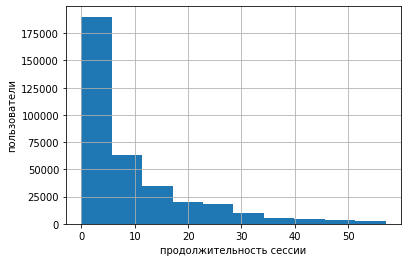

Длительность сессии


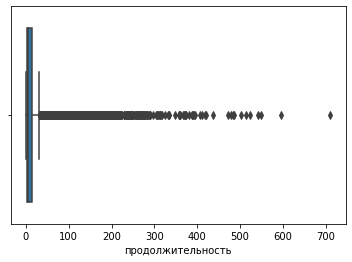

None


In [31]:
#рассмотрим на графике среднюю продолжительность сессии
def analyz(session_duration):
    print ('Длительность сессии')
    percentile_95 = np.percentile(visits['session_duration'], 95)
    ax = visits['session_duration'].hist(range = (0, percentile_95*1.5))
    ax.set_xlabel('продолжительность сессии')
    ax.set_ylabel('пользователи')
    plt.show()
    print('Длительность сессии')
    ax = sns.boxplot(visits['session_duration'])
    ax.set_xlabel('продолжительность')
    plt.show()
print(analyz('session_duration'))

Половина пользователей пребывают на сайте не более 5 минут

#### рассмотрим как часто люди возвращаются?

In [32]:
#Для каждого клиента получим дату его первого заказа
first_activity_date = visits.groupby(['uid'])['start_ts'].min()
first_activity_date.name = 'first_activity_date'

In [33]:
#Добавим в основную таблицу столбец first_activity_date с датами первой покупки клиента.
visits = visits.join(first_activity_date,on='uid')

In [34]:
#создадим столбец activity_month, в котором сохраним месяц, извлечённый из значений столбца start ts
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')
visits['activity_month'] = visits['start_ts'].astype('datetime64[M]')

In [35]:
#Найдем lifetime («время жизни») для каждого события, преобразуем тип данных в число месяцев, прошедших между датами
visits['lifetime'] = round((visits['activity_month'] - visits['first_activity_month'])/np.timedelta64(1,'M')).astype('int')

In [36]:
#Создадим новый датафрейм со столбцами first_activity_month- 
#содержит когорту, сформированную на основе месяца первой покупки 
#и lifetime — порядковый номер относительно месяца первой покупки
cohorts = visits.groupby(['first_activity_month', 'lifetime']).agg({'uid':'nunique'}).reset_index()

In [37]:
#Сгруппируем новую таблицу users_count, 
#в которой для каждой когорты будет отображено число пользователей на нулевую неделю lifetime.
users_count = cohorts[cohorts['lifetime'] == 0][['first_activity_month','uid']]

In [38]:
users_count = users_count.rename(columns={'uid':'cohort_users'})


In [39]:
#Объединим датафрейм cohorts и users_count по столбцу с месяцами когорты
cohorts = cohorts.merge(users_count, on='first_activity_month')

In [40]:
#Рассчитаем сколько пользователей из когорты относительно их изначального числа вернулось в последующие периоды
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']

In [41]:
retention_pivot = cohorts.pivot_table(index='first_activity_month', columns='lifetime', values='retention', aggfunc='sum')
retention_pivot

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


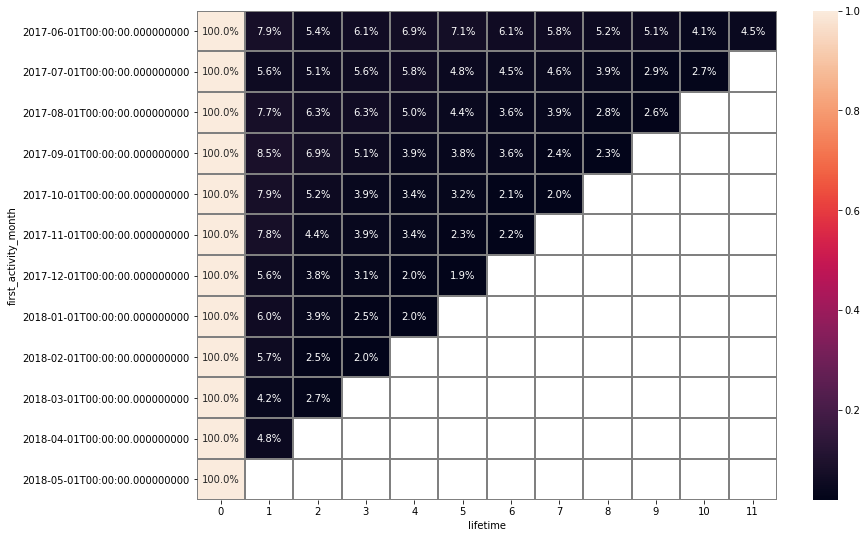

In [42]:
plt.figure(figsize=(13, 9))
plt.title='Когортный анализ'
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray')
plt.show()

Исходя из приведенных данных тенденция невозврата пользователей прослеживается в каждой отдельной когорте что в целом представляет единую тенденцию

## <span style="color:red">ДОПОЛНЕНИЕ</span>
Процент возврата невелик, имеет тенденцию к понижению, что составляет в среднем трехкратное снижение возврата пользователей

## Продажи
- Когда люди начинают покупать?
- Сколько раз покупают за период?
- Какой средний чек?
- Сколько денег приносят? (LTV)

#### Когда люди начинают покупать?

In [43]:
#Создадим таблицу order_len с первым визитом и первой покупкой
first_order_day = orders.groupby('uid').agg({'buy_ts':'min'}).rename(columns={'buy_ts':'first_order_date'}).reset_index()
first_visit_day = visits.groupby('uid').agg({'start_ts':'min'}).rename(columns={'start_ts':'first_visit_date'}).reset_index()
order_len = first_visit_day.merge(first_order_day, on='uid')

In [44]:
order_len['order_day'] = order_len['first_order_date'].astype('datetime64[D]')
order_len['session_day'] = order_len['first_visit_date'].astype('datetime64[D]')

In [45]:
#найдем день начала покупки
order_len['order_start'] = ((order_len['order_day']-order_len['session_day'])/np.timedelta64(1,'D')).astype('int')

In [46]:
order_len['order_start'].describe()

count    36523.000000
mean        16.895901
std         47.071200
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        363.000000
Name: order_start, dtype: float64

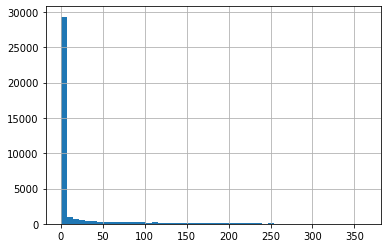

In [47]:
order_len['order_start'].hist(bins=50)

Определенно большинство пользователей начинают совершать покупки в день первого посещения

#### Сколько раз покупают за период?

In [48]:
#Создадим новую таблицу с днями покупки, неделей и месяцем
visits_orders = first_visit_day.merge(orders)


In [49]:
visits_orders['buy_day']=visits_orders['buy_ts'].dt.date
visits_orders['buy_week']=visits_orders['buy_ts'].dt.week
visits_orders['buy_month']=visits_orders['buy_ts'].dt.month

In [50]:
#Сколько покупок в день
buy_per_day = visits_orders.groupby('buy_day')['uid'].count()


In [51]:
buy_per_day.describe()

count    364.000000
mean     138.502747
std       76.858480
min        1.000000
25%       82.750000
50%      136.000000
75%      177.000000
max      814.000000
Name: uid, dtype: float64

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


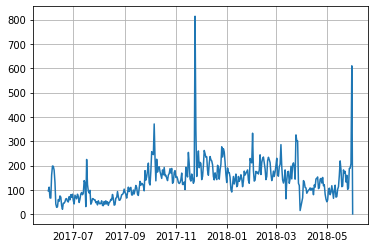

In [52]:
plt.plot(buy_per_day)
plt.xlim=10
plt.grid()
plt.show()

In [53]:
#сколько покупок в неделю
buy_per_week = visits_orders.groupby('buy_week')['uid'].count()
buy_per_week

buy_week
1     1006
2      942
3      991
4     1128
5     1442
6     1272
7     1368
8     1347
9     1252
10    1293
11    1007
12    1418
13     862
14     733
15     698
16     890
17     890
18     547
19     635
20    1004
21    1027
22    1536
23     938
24     343
25     371
26     460
27     477
28     636
29     716
30     381
31     314
32     325
33     392
34     480
35     588
36     666
37     668
38     826
39    1110
40    1666
41    1270
42    1140
43    1132
44    1059
45     919
46    1257
47    1894
48    1387
49    1520
50    1388
51    1184
52    1620
Name: uid, dtype: int64

In [54]:
buy_per_week.describe()

count      52.000000
mean      969.519231
std       397.630457
min       314.000000
25%       658.500000
50%       997.500000
75%      1270.500000
max      1894.000000
Name: uid, dtype: float64

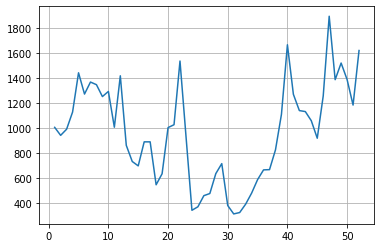

In [55]:
plt.plot(buy_per_week)
plt.xlim=10
plt.grid()
plt.show()

In [56]:
#Сколько покупок в месяц
buy_per_month = visits_orders.groupby('buy_month')['uid'].count()


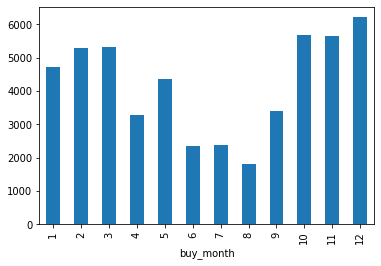

In [57]:
buy_per_month.plot(kind='bar')

In [58]:
buy_per_month.describe()

count      12.000000
mean     4201.250000
std      1511.861052
min      1807.000000
25%      3045.500000
50%      4533.500000
75%      5409.250000
max      6218.000000
Name: uid, dtype: float64

Исходя из расчетов можно сказать что в среднем ежедневно совершается 138 покупок, но бывают дни когда за весь день происходит лишь одна сделка, а бывают и плодотворные дни когда за день проходит 814 покупок.
Если смотреть по неделям то здесь есть недели когда за весь период лишь 314 продажи, но в среднем 970 сделок.
Таким образом в среднем за месяц зафиксировали 4201 покупку, самые низкие показатели у августа 1807 продаж а самые высокие в декабре 6218

## <span style="color:red">ДОПОЛНЕНИЕ</span>
Данный сервис четко показывает зависимость числа пользователей от сезонности. В летние месяцы покупок становится меньше более чем в 2 раза. Это скорее всего связано с иными возможностями проведения досуга у потребителей

#### Какой средний чек?

In [59]:
mean_order_month=visits_orders.groupby('buy_month').agg({'revenue':'mean'})


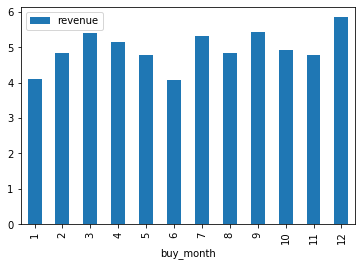

In [60]:
mean_order_month.plot(kind='bar')

In [61]:
standard_deviation = np.std(mean_order_month['revenue'])
standard_deviation

0.4991138712873802

В декабре средний чек выше в отличии от других месяцев, январь и июнь показывают минимум. Средний чек колеблется от 4 до почти 6 у.е.

## <span style="color:red">ДОПОЛНЕНИЕ</span>
Исходя из показателей стандартного отклонения колебания среднего чека незначительны

#### Сколько денег приносят? (LTV)

LTV «пожизненная» ценность клиента — итоговая сумма денег, которую один клиент приносит в среднем со всех своих покупок. Найдем валовую прибыль с клиента за период.

In [62]:
#добавим столбец с месяцем покупки
orders = orders.set_index('uid')
orders['buy_month'] = orders['buy_ts'].astype('datetime64[M]')

In [63]:
costs_ltv = costs.rename(columns={'dt':'n_date'})

In [64]:
# сгруппируем новую таблицу пользователей с датой первой сессии
users=visits.groupby('uid').agg({'start_ts':'min'}).rename(columns={'start_ts':'n_dt'})


In [65]:
users=visits.set_index('uid').join(users)


In [66]:
#из обобщенной таблицы сгруппируем новую таблицу с идентификатор рекламного источника, из которого пришел пользователь
#уникальным id пользователя, который сделал заказ, источником и месяцем первой сессии
users=users.query('start_ts == n_dt')
users=users.query('start_ts == n_dt')[['n_dt', 'device','source_id']]
users['n_date']=users['n_dt'].dt.date
users['n_date']=users['n_date'].astype('datetime64[M]')


In [67]:
users['n_month']=users['n_dt'].astype('datetime64[M]')

In [68]:
#сгруппируем подготовительные таблицы для дальнейших расчетов
users=users.reset_index().set_index(['source_id','n_date'])

In [69]:
costs_ltv = costs_ltv.set_index(['source_id','n_date'])

In [70]:
users=users.join(costs_ltv, how='left')

In [71]:
#таблица для рассчета во сколько обходится новый клиент
cac=(users.reset_index().groupby(['source_id','n_date']).
     agg({'device':'count','costs':max}).rename(columns={'device':'users'}))

In [72]:
#для расчета разделим затраты на юзеров
cac['n_cost']=cac['costs']/cac['users']

In [73]:
users=users.join(cac[['n_cost','users']], how='left').reset_index()

In [74]:
#таблица для расчета суммы денег, которую один клиент приносит в среднем со всех своих покупок
ltv=orders.join(users.set_index('uid'), how='left')[['n_month','buy_month','revenue']]

In [75]:
#добавим в таблицу столбец с возрастом каждой когорты в месяцах
ltv['age_month']=((ltv['buy_month']-ltv['n_month'])/np.timedelta64(1,'M')).round().astype('int')
ltv=ltv.groupby(['n_month','age_month']).agg({'revenue':'sum'})
ltv=ltv.pivot_table(index='n_month', columns='age_month', values='revenue', aggfunc='sum')

In [76]:
#посчитаем накопительный LTV  после первой покупки
ltv=ltv.cumsum(axis=1)
ltv

age_month,0,1,2,3,4,5,6,7,8,9,10,11
n_month,,,,,,,,,,,,
2017-06-01,9557.49,12222.07,13686.76,17568.85,21509.44,24333.92,27823.87,30094.68,32412.59,35894.23,38098.24,40026.05
2017-07-01,9874.89,10934.17,12043.07,13026.03,13873.02,14671.10,15259.10,16029.40,16753.92,17344.95,17812.11,NaN
2017-08-01,6234.81,7232.13,8233.48,9179.69,9989.73,10522.63,11009.28,12255.51,13086.15,13461.87,NaN,NaN
2017-09-01,12357.20,16057.68,18168.31,28607.24,29895.72,31805.77,32772.61,33263.99,33682.56,NaN,NaN,NaN
2017-10-01,18362.32,22172.15,23499.17,24557.22,25600.69,26622.88,27201.79,27857.69,NaN,NaN,NaN,NaN
2017-11-01,16531.79,19199.37,20542.22,21911.75,23020.49,23728.12,24426.72,NaN,NaN,NaN,NaN,NaN
2017-12-01,16857.00,18596.03,22794.33,27918.15,29375.72,31157.85,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,10597.01,12548.71,13713.47,14019.35,14546.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,11512.63,13497.09,14160.28,15061.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
cohorts=(users.groupby('n_month').
         agg({'device':'count', 'n_cost':'sum'}).rename(columns={'device':'cohort_size'}))


In [78]:
ltv=cohorts[['cohort_size']].join(ltv)


In [79]:
#для расчета LTV с помощью команды div разделим наши данные столбцов на cohort_size
ltv=ltv.div(ltv['cohort_size'],axis=0).drop(columns=['cohort_size'])
ltv

,0,1,2,3,4,5,6,7,8,9,10,11
n_month,,,,,,,,,,,,
2017-06-01,0.720830,0.921794,1.032262,1.325051,1.622252,1.835276,2.098489,2.269755,2.444573,2.707160,2.873387,3.018783
2017-07-01,0.751514,0.832129,0.916520,0.991326,1.055785,1.116522,1.161271,1.219893,1.275032,1.320011,1.355564,NaN
2017-08-01,0.612397,0.710356,0.808710,0.901649,0.981213,1.033556,1.081355,1.203763,1.285350,1.322254,NaN,NaN
2017-09-01,0.739775,0.961307,1.087662,1.712598,1.789734,1.904081,1.961962,1.991379,2.016437,NaN,NaN,NaN
2017-10-01,0.706868,0.853530,0.904614,0.945345,0.985514,1.024864,1.047149,1.072398,NaN,NaN,NaN,NaN
2017-11-01,0.606716,0.704616,0.753898,0.804160,0.844851,0.870821,0.896459,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.667128,0.735952,0.902103,1.104882,1.162566,1.233095,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.468397,0.554664,0.606147,0.619667,0.642982,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.518657,0.608059,0.637937,0.678528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


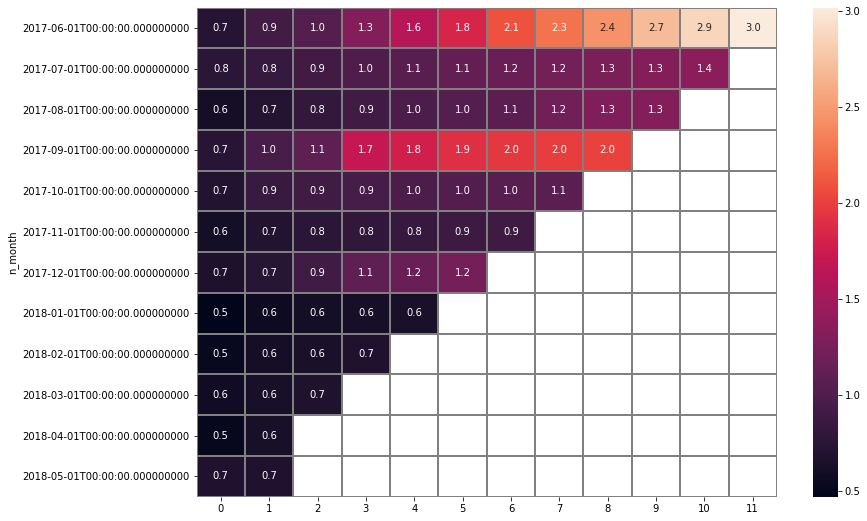

In [80]:
plt.figure(figsize=(13, 9))
plt.title='LTV'
sns.heatmap(ltv, annot=True, fmt='.1f', linewidths=1, linecolor='gray')

Неплохая динамика у первой и четвертой когорты, но в общем все примерно идут с одной скоростью роста

### Маркетинг
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько стоило привлечение одного покупателя из каждого источника?
- На сколько окупились расходы? (ROI)

#### Сколько денег потратили? Всего

In [81]:
total_costs=costs['costs'].sum()
total_costs

329131.62

всего потрачено на рекламу 329131.62

In [82]:
costs['month']=costs['dt'].astype('datetime64[M]').dt.date

In [83]:
#сгруппируем помесячно
month_costs=costs.groupby('month')['costs'].sum()


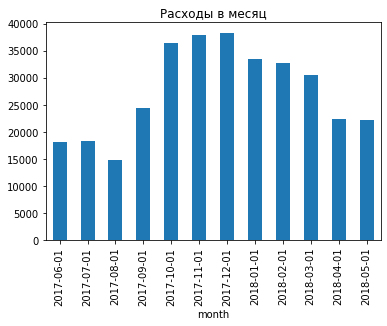

In [84]:
month_costs.plot(kind='bar', title='Расходы в месяц')

Самые высокие затраты с октября по январь

In [85]:
sours_costs=costs.groupby('source_id')['costs'].sum()
sours_costs

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

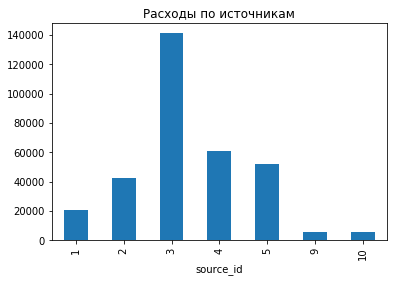

In [86]:
sours_costs.plot(kind='bar', title='Расходы по источникам')

#### Сколько стоило привлечение одного покупателя из каждого источника?

In [87]:
#из visits вычленяем uid и sours_id,  то что получилось мерджим с orders, 
# получаем таблицу, из которой группируем для каждого уникального uid каждый источник
uid_source=visits.groupby('uid')['source_id'].mean().astype('int')
order_source=pd.merge(orders,uid_source, on='uid').reset_index()
source_size = order_source.groupby('source_id').agg({'uid':'nunique'})


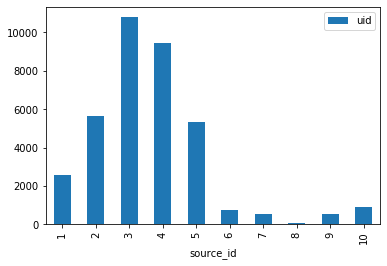

In [88]:
source_size.plot(kind='bar')

In [89]:
#сформируем таблицу где для каждого юзера соответствует сас, идентификатор рекламного источника,
#затраты на этот рекламный источник
costs_sourse_total=pd.merge(sours_costs,source_size, on='source_id')
costs_sourse_total['cac']=costs_sourse_total['costs']/costs_sourse_total['uid']


In [90]:
total_orders=order_source.groupby('source_id').agg({'revenue':'sum'}).reset_index()
roi=pd.merge(sours_costs,total_orders, on='source_id')
roi['roi']=(roi['revenue']-roi['costs'])*100/roi['costs']

In [166]:
roi

,source_id,costs,revenue,roi
0,1,20833.27,36352.44,74.492242
1,2,42806.04,76215.84,78.049266
2,3,141321.63,58209.70,-58.810481
3,4,61073.60,45157.22,-26.060982
4,5,51757.10,25286.58,-51.143746
5,9,5517.49,1920.19,-65.198125
6,10,5822.49,2446.22,-57.986703


Лишь два источника показывают положительный результат, другие убыточные

# ВЫВОД

Данные по пользователям, их возврату на ресурс, а также тенденции покупок свидетельствуют, что бизнес модель вырабатывет только спонтанные вспелески продаж, без тенденции к развитию. В промежуточных выводах не прослеживается четких маркеров, манипуляции с которыми могли бы привести к устойчивому росту. Это по видимому связано с тем, что первичные действия в виде удержания клиентов (возврат пользователей) нерезультативны. Поэтому и возврат клиентов практически отсутсвует. Отсувие возврата клиентов не может обеспечить постоянный рост стабильных продаж. Таким образом, напрашивается вывод, что эта модель продаж находится в прямой зависимости от факторов или обстоятелсьтв, во время возникновения которых происходят вспелески интереса пользователей, но отсувует стабильность роста пользователей и продаж.

В глаза бросается большая текучесть, люди приходят и не возвращаются, а затраты на рекламу окупаются лишь у двух источников, значит от других надо либо отказаться либо пересмотреть условия и формат.